Сделаем Базу Данных для хранения всех текстов. Таким образом у нас будет чёткое разграничение по артистам, буде удобно всё хранить.

Необходимые импорты:

In [ ]:
# ! pip install langdetect

In [1]:
import json
import os
import zipfile
import shutil
import re
import sqlite3
from string import punctuation
from nltk import sent_tokenize, word_tokenize
from langdetect import detect
import spacy
from spacy.lang.ru.examples import sentences
import tqdm

ModuleNotFoundError: No module named 'langdetect'

Всего в БД 2 таблицы:

1. Исполнители (ключ, имя и жанр, к которому его относят)

2. Песни (ключ, id исполнителя, название, год, альбом, текст песни, лемматизированный текст)

In [ ]:
corpname = 'Chanson_françaises_XX'

In [ ]:
def create_database(db_name):
    """Создает БД с таблицами для авторов и песен."""
    conn = sqlite3.connect(f"{db_name}.db")
    cur = conn.cursor()

    cur.execute('''
        CREATE TABLE IF NOT EXISTS author (
            id INTEGER PRIMARY KEY,
            name TEXT,
            genre TEXT
        )
    ''')

    cur.execute('''
        CREATE TABLE IF NOT EXISTS song (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            author_id INTEGER,
            title TEXT,
            date INTEGER,
            album TEXT,
            lyrics TEXT,
            FOREIGN KEY(author_id) REFERENCES author(id)
        )
    ''')
    conn.commit()
    return conn

Ниже паттерны, которые нам нужны для хорошей обработки.

In [ ]:
pattern_br = re.compile('\(.+\)')
pattern_encl = re.compile('(.+?)[\?\.\;\:\!\n]+ ?')
pattern_text = re.compile('(.+) \(.+\)')
pattern_date = re.compile('\d{4}')
stripadd = re.compile('.+\]\n')
punct = punctuation + '...' + '``' + '\'\'' + '«' + '»' + '—' + ' '
trash = ['rmx', 'edit', 'round', 'cover', 'Contributors', 'Contributor', 'Translations', 'English', 'Lyrics','freestyle', 'live', 'mix', 'remix', 'skit', 'ark']

У нас французский язык

In [ ]:
# ! python -m spacy download fr_core_news_sm

In [ ]:
nlp = spacy.load("fr_core_news_sm")

Начинаем обработку. Расспакуем нашу папку со всеми json файлами.

In [ ]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
extract_to = 'temp_zip_extract'
extract_zip('/content/drive/MyDrive/Диплом/Песни тексты.zip', extract_to)

Поскольку песни на других языках (английский и итальянский) тоже есть у исполнителей, то нам обязательно надо проверять текст. Достаточно посмотреть на первые 100 слов.

In [ ]:
def is_french(text, threshold=0.7):
    try:
        return detect(text) == 'fr'
    except:
        return False

In [ ]:
def extract_date(rel_date, rel_ford):
    if rel_date:
        d_text = pattern_date.search(rel_date)
        if d_text:
            date = d_text.group(0)
    elif rel_ford:
        df_text = pattern_date.search(rel_ford)
        if df_text:
            date = df_text.group(0)
        else:
            date = '0'
    else:
        date = '0'
    return int(date)

In [ ]:
def release_from_brakes(el, obj):
    p_text = pattern_text.search(obj[el])
    if p_text:
        element = p_text.group(1)
    else:
        element = obj[el]
    return element

In [ ]:
def get_album(song):
    try:
        if song['album']['name']:
            album = release_from_brakes('name', song['album'])
            return album
    except:
        return 'undefined'

In [ ]:
def find_additional(lines):
    extracted_lines = []
    for line in lines:
        if line:
            check_brake = pattern_br.search(line)
            if check_brake:
                additional_line = check_brake.group(0)
                clean_original = line.replace(additional_line, '')
                if clean_original:
                    extracted_lines.append(clean_original)
                extracted_lines.append(additional_line)
            else:
                extracted_lines.append(line)
    return extracted_lines

In [ ]:
def get_lyrics(genius_raw):
    if genius_raw:
        without_unicode = genius_raw.replace('\u2005', ' ').replace('\xa0', ' ')  # Заменяем не-классические табуляции на классические
        for word in trash:
          without_unicode = without_unicode.replace(word, '')
        without_unicode = ''.join(filter(lambda x: not x.isdigit(), without_unicode))
        without_comments = stripadd.sub('', without_unicode).replace('\n\n', '\n').strip('\n')  # Удаляем текст из скобок
        return without_comments

In [ ]:
def process_song(song):
    """
    Очищает текст, проверяет язык, разбивает на предложения.
    Возвращает очищенный текст и лемматизированные предложения.
    """
    lyrics = get_lyrics(song.get('lyrics', ''))
    if not lyrics or not is_french(lyrics):
        return None, None
    return lyrics

In [ ]:
def process_author_json(author_json, conn, author_id, genre='undefined'):
    """
    Обрабатывает JSON артиста:
    - Записывает данные об артисте в БД
    - Обрабатывает все песни, добавляет их в БД
    """
    cur = conn.cursor()
    author_name = release_from_brakes('name', author_json)
    cur.execute('INSERT OR IGNORE INTO author (id, name, genre) VALUES (?, ?, ?)', (author_id, author_name, genre))
    conn.commit()

    for idx, song in enumerate(author_json.get('songs', [])):
        date = extract_date(song['release_date'], song['release_date_for_display'])
        title = release_from_brakes('title', song)
        album = get_album(song)

        lyrics = process_song(song)
        if type(lyrics) != tuple:
          cur.execute('''
              INSERT INTO song (author_id, title, date, album, lyrics)
              VALUES (?, ?, ?, ?, ?)
          ''', (author_id, title, date, album, lyrics))
          conn.commit()

In [ ]:
def process_corpus(json_folder, db_name):
    conn = create_database(db_name)
    author_id = 0

    for file_name in os.listdir(json_folder):
        if file_name.endswith('.json'):
            with open(os.path.join(json_folder, file_name), 'r', encoding='utf-8') as f:
                author_json = json.load(f)
            process_author_json(author_json, conn, author_id)
            author_id += 1

    conn.close()

In [ ]:
process_corpus('/content/temp_zip_extract/ÅÑß¡¿ ΓÑ¬ßΓδ', 'Chanson_françaises_XX')

После ручной проверки данных делаем аналитику по корпусу. В чём заключалась проверка:

- проставить даты, где их не было

- убрать повторы песен, которые не ушли при создании БД (live version, например)

- проверить на адекватность даты, так как иногда песню могут отнести к альбому, который был выпущен после смерти исполнителя

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd

In [6]:
con = sqlite3.connect('Chanson_françaises_XX.db')
cur = con.cursor()

In [7]:
query = "SELECT * FROM song"

In [8]:
df = pd.read_sql(query, con)

In [9]:
con.close()

In [10]:
songs_per_year = df['date'].value_counts().sort_index()

<ipython-input-11-081a6924aa77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=songs_per_year.index, y=songs_per_year.values, palette="viridis")


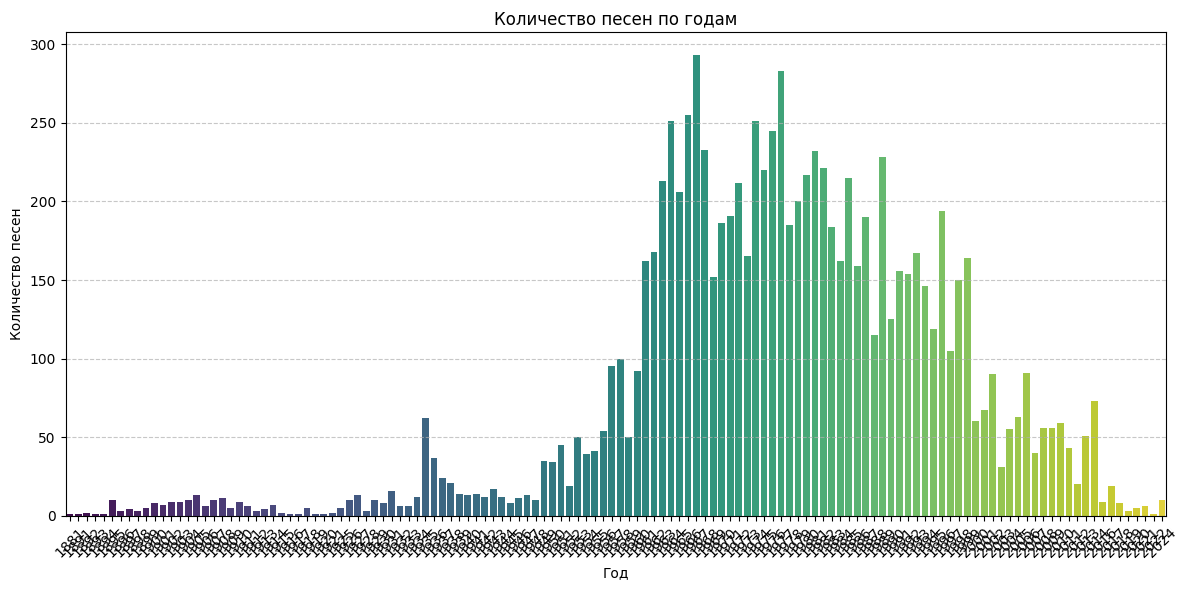

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, palette="viridis")
plt.title('Количество песен по годам')
plt.xlabel('Год')
plt.ylabel('Количество песен')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Попробуем скорректировать выборку, чтобы не было больших пиков. Откажемся от некоторых исполнителей, которые преобладают с 60-ых до 90-ых. Хоть это и логично, но лучше немного скорректировать.

In [37]:
con = sqlite3.connect('Chanson_françaises_XX.db')

#Распределение песен по декадам
decade_distribution = pd.read_sql("""
    SELECT
        (date / 10) * 10 AS decade,
        COUNT(*) AS song_count
    FROM song
    GROUP BY decade
    ORDER BY decade
""", con)

print(decade_distribution)

    decade  song_count
0     1880           1
1     1890          30
2     1900          88
3     1910          39
4     1920          44
5     1930         206
6     1940         145
7     1950         527
8     1960        2025
9     1970        2138
10    1980        1923
11    1990        1480
12    2000         609
13    2010         285
14    2020          22


Посмотрим на исполнителей популярных по декадам.

In [38]:
top_authors = pd.read_sql("""
    WITH decade_author_counts AS (
        SELECT
            (SUBSTR(s.date, 1, 3) || '0') AS decade,
            a.name AS author,
            COUNT(*) AS songs_count,
            ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY (SUBSTR(s.date, 1, 3) || '0')), 2) AS percent
        FROM song s
        JOIN author a ON s.author_id = a.id
        GROUP BY decade, a.name
    )
    SELECT decade, author, songs_count, percent || '%' AS share
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY decade ORDER BY songs_count DESC) AS rank
        FROM decade_author_counts
    )
    WHERE rank <= 3
    ORDER BY decade, rank
""", con)

print(top_authors)

   decade                  author  songs_count   share
0    1880                  Dranem            1  100.0%
1    1890         Théodore Botrel           11  36.67%
2    1890         Yvette Guilbert           11  36.67%
3    1890                  Dranem            6   20.0%
4    1900         Théodore Botrel           41  46.59%
5    1900             Félix Mayol           27  30.68%
6    1900         Yvette Guilbert           15  17.05%
7    1910         Yvette Guilbert           13  33.33%
8    1910             Félix Mayol           10  25.64%
9    1910                  Dranem            5  12.82%
10   1920       Maurice Chevalier           35  79.55%
11   1920                  Dranem            7  15.91%
12   1920             Jean Sablon            1   2.27%
13   1930       Maurice Chevalier          107  51.94%
14   1930              Édith Piaf           31  15.05%
15   1930          Charles Trenet           30  14.56%
16   1940              Édith Piaf           50  34.48%
17   1940 

Наша задача сбалансировать 4 декады, чтобы не было настолько сильных перекосов в сторону больше 2000 песен на декаду.

Мы введём пропорции и минимум песен, которые должны сохраниться у исполнителя, чтобы мы не потеряли часть его творчества.

Как будет проходить процесс балансировки:

Отделим 4 целевые декады (1960-1990) от остальных

Для каждой декады рассчитаем общее количество песен для сохранения (60% от исходного), чтобы мы не сократили сильно-сильно.

Каждый автор оставляет гарантированные 3 песни (или все, если их меньше). Оставшиеся проценты распределяем пропорционально, но не более 8% на исполнителя

Случайно выбираем песни по квотам (с фиксированным random_state для воспроизводимости)

Объединяем сбалансированные декады с остальными песнями (до 1960 и после 1990)

In [128]:
TARGET_DECADE_RATIO = {
    '1960':1,
    '1970': 1,
    '1980': 1,
    '1990': 1
}
MAX_ARTIST_SHARE = 0.1  #Максимальная доля одного исполнителя
MIN_SONGS_PER_ARTIST = 3  #Минимум песен на исполнителя
RANDOM_SEED = 42

In [120]:
def get_decade(year):
    return str(year)[:3] + '0'

In [121]:
def load_all_songs(db_path):
    con = sqlite3.connect(db_path)
    query = """
        SELECT s.id, s.title, s.date, a.name AS author, s.lyrics
        FROM song s JOIN author a ON s.author_id = a.id
    """
    df = pd.read_sql(query, con)
    df['decade'] = df['date'].apply(get_decade)
    con.close()
    return df

In [146]:
def balance_selected_decades(df):
    #Отделяем песни для балансировки
    to_balance = df[df['decade'].isin(TARGET_DECADE_RATIO.keys())].copy()
    other_songs = df[~df['decade'].isin(TARGET_DECADE_RATIO.keys())].copy()

    #Сохраняем исходные пропорции между декадами
    decade_ratios = to_balance['decade'].value_counts(normalize=True)

    #Целевое количество песен (оставляем 60% от исходного)
    target_total = int(len(to_balance) * 0.6)

    balanced_dfs = []
    for decade in TARGET_DECADE_RATIO:
        decade_df = to_balance[to_balance['decade'] == decade].copy()
        target_count = int(target_total * decade_ratios[decade])

        #Распределяем квоты между исполнителями
        author_counts = decade_df['author'].value_counts()
        author_limits = {}

        #1. Гарантируем минимум песен каждому исполнителю
        for author in author_counts.index:
            author_limits[author] = min(MIN_SONGS_PER_ARTIST, author_counts[author])

        #2. Распределяем оставшиеся места с учетом MAX_ARTIST_SHARE
        remaining = target_count - sum(author_limits.values())
        if remaining > 0:
            authors = author_counts.index.tolist()
            while remaining > 0 and authors:
                for author in authors[:]:  #Копия для безопасного удаления
                    max_allowed = min(
                        int(target_count * MAX_ARTIST_SHARE),
                        author_counts[author]
                    )
                    if author_limits[author] < max_allowed:
                        author_limits[author] += 1
                        remaining -= 1
                        if remaining == 0:
                            break
                    else:
                        authors.remove(author)

        #Выбираем песни
        selected_songs = []
        for author, limit in author_limits.items():
            author_songs = decade_df[decade_df['author'] == author]
            selected_songs.append(
                author_songs.sample(n=limit, random_state=RANDOM_SEED)
            )

        balanced_dfs.append(pd.concat(selected_songs))

    #Объединяем результаты
    balanced_part = pd.concat(balanced_dfs)
    return pd.concat([balanced_part, other_songs])

In [123]:
def save_all_songs(original_db, all_songs_df):
    new_db = original_db.replace('.db', '_balanced.db')

    con_new = sqlite3.connect(new_db)
    cur = con_new.cursor()

    #Создаем таблицы
    cur.execute("DROP TABLE IF EXISTS song")
    cur.execute("DROP TABLE IF EXISTS author")

    #Таблица author
    cur.execute("""
        CREATE TABLE author (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL UNIQUE
        )
    """)

    #Таблица song
    cur.execute("""
        CREATE TABLE song (
            id INTEGER PRIMARY KEY,
            author_id INTEGER NOT NULL,
            title TEXT NOT NULL,
            date INTEGER,
            lyrics TEXT,
            FOREIGN KEY (author_id) REFERENCES author(id)
        )
    """)

    #1. Сохраняем всех уникальных авторов
    authors = all_songs_df[['author']].drop_duplicates()
    authors = authors.reset_index(drop=True)
    authors['id'] = authors.index + 1

    cur.executemany(
        "INSERT INTO author (id, name) VALUES (?, ?)",
        authors[['id', 'author']].values.tolist()
    )

    #2. Сохраняем все песни
    songs = all_songs_df.merge(authors, on='author')
    songs = songs[['id_x', 'id_y', 'title', 'date', 'lyrics']]

    cur.executemany(
        "INSERT INTO song (id, author_id, title, date, lyrics) VALUES (?, ?, ?, ?, ?)",
        songs.values.tolist()
    )

    con_new.commit()
    con_new.close()

In [147]:
db_path = 'Chanson_françaises_XX.db'
all_songs = load_all_songs(db_path)

In [148]:
print("Исходное распределение:")
print(all_songs['decade'].value_counts().sort_index())

Исходное распределение:
decade
1880       1
1890      30
1900      88
1910      39
1920      44
1930     206
1940     145
1950     527
1960    2025
1970    2138
1980    1923
1990    1480
2000     609
2010     285
2020      22
Name: count, dtype: int64


In [149]:
balanced_songs = balance_selected_decades(all_songs)

In [150]:
print("\nПосле балансировки:")
print(balanced_songs['decade'].value_counts().sort_index())


После балансировки:
decade
1880       1
1890      30
1900      88
1910      39
1920      44
1930     206
1940     145
1950     527
1960    1214
1970    1282
1980    1153
1990     887
2000     609
2010     285
2020      22
Name: count, dtype: int64


In [151]:
save_all_songs(db_path, balanced_songs)
print(f"Сохранено в {db_path.replace('.db', '_balanced.db')}")

Сохранено в Chanson_françaises_XX_balanced.db


In [152]:
con = sqlite3.connect('Chanson_françaises_XX_balanced.db')
cur = con.cursor()

In [153]:
query = "SELECT * FROM song"

In [154]:
df = pd.read_sql(query, con)

In [155]:
con.close()

In [156]:
songs_per_year = df['date'].value_counts().sort_index()

<ipython-input-157-081a6924aa77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=songs_per_year.index, y=songs_per_year.values, palette="viridis")


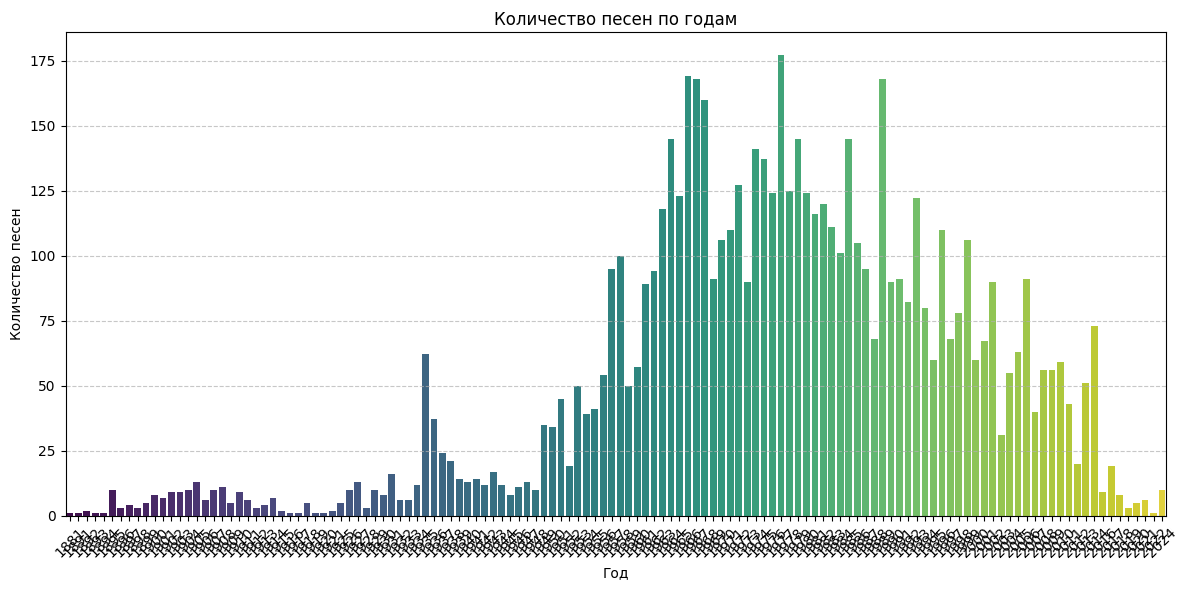

In [157]:
plt.figure(figsize=(12, 6))
sns.barplot(x=songs_per_year.index, y=songs_per_year.values, palette="viridis")
plt.title('Количество песен по годам')
plt.xlabel('Год')
plt.ylabel('Количество песен')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [158]:
con = sqlite3.connect('/content/Chanson_françaises_XX_balanced.db')

In [159]:
top_authors = pd.read_sql("""
    WITH decade_author_counts AS (
        SELECT
            (SUBSTR(s.date, 1, 3) || '0') AS decade,
            a.name AS author,
            COUNT(*) AS songs_count,
            ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY (SUBSTR(s.date, 1, 3) || '0')), 2) AS percent
        FROM song s
        JOIN author a ON s.author_id = a.id
        GROUP BY decade, a.name
    )
    SELECT decade, author, songs_count, percent || '%' AS share
    FROM (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY decade ORDER BY songs_count DESC) AS rank
        FROM decade_author_counts
    )
    WHERE rank <= 3
    ORDER BY decade, rank
""", con)

print(top_authors)

   decade                  author  songs_count   share
0    1880                  Dranem            1  100.0%
1    1890         Théodore Botrel           11  36.67%
2    1890         Yvette Guilbert           11  36.67%
3    1890                  Dranem            6   20.0%
4    1900         Théodore Botrel           41  46.59%
5    1900             Félix Mayol           27  30.68%
6    1900         Yvette Guilbert           15  17.05%
7    1910         Yvette Guilbert           13  33.33%
8    1910             Félix Mayol           10  25.64%
9    1910                  Dranem            5  12.82%
10   1920       Maurice Chevalier           35  79.55%
11   1920                  Dranem            7  15.91%
12   1920             Jean Sablon            1   2.27%
13   1930       Maurice Chevalier          107  51.94%
14   1930              Édith Piaf           31  15.05%
15   1930          Charles Trenet           30  14.56%
16   1940              Édith Piaf           50  34.48%
17   1940 

Почему сделали именно так:

Сохраненяем разных артистов, чтобы ни одного не потерять.

Пропорциональное распределение уменьшает статистические искажения

Фиксированный random_state обеспечивает воспроизводимость результатов

Плюс, можем ещё сократить, так как параметры гибкие и мы можем их менять.

Должны сохранить достаточно данных для выявления трендов и при этом удалить "шум" от чрезмерно представленных авторов. Хотя некоторые топы всё же остануться.

In [164]:
def get_statistics(db_path):
    con = sqlite3.connect(db_path)
    try:
        stats = {}

        # Общее количество песен
        cur = con.cursor()
        cur.execute("SELECT COUNT(*) FROM song")
        stats['total_songs'] = cur.fetchone()[0]

        # Количество исполнителей
        cur.execute("SELECT COUNT(*) FROM author")
        stats['total_artists'] = cur.fetchone()[0]

        # Статистика по десятилетиям
        cur.execute("""
            SELECT
                (date/10)*10 as decade,
                COUNT(*) as count
            FROM song
            GROUP BY decade
            ORDER BY decade
        """)
        stats['by_decade'] = dict(cur.fetchall())

        for k, v in stats.items():
            print(f"{k}: {v}")

    finally:
        con.close()

In [165]:
get_statistics('/content/Chanson_françaises_XX_balanced.db')

total_songs: 6532
total_artists: 91
by_decade: {1880: 1, 1890: 30, 1900: 88, 1910: 39, 1920: 44, 1930: 206, 1940: 145, 1950: 527, 1960: 1214, 1970: 1282, 1980: 1153, 1990: 887, 2000: 609, 2010: 285, 2020: 22}
